# Import everything

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import math
import multiprocessing
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from timeit import default_timer as timer
from datetime import timedelta
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz
from itertools import combinations
import openpyxl
from scipy.stats import pearsonr
from matplotlib import colors as mcolors
from functions import eegplot

# Read powers and phases

In [2]:
df_power = pd.read_csv('166-d3-powers-v2.csv')
df_phase = pd.read_csv('166-d3-phases-v2.csv')

In [3]:
# Fix some columns and values for readability.
df_power.loc[df_power['EEG'] == 'Average', 'EEG'] = "M1 Average"
df_power.loc[df_power['Time'] == -250, 'Time'] = "-250ms"
df_power.loc[df_power['Time'] == -750, 'Time'] = "-750ms"
df_power = df_power.rename(columns={'ArtifactRemoved': 'Artifact Removed'})
df_power = df_power.rename(columns={'trial': 'trial_abs'})
df_phase.loc[df_phase['EEG'] == 'Average', 'EEG'] = "M1 Average"
df_phase = df_phase.rename(columns={'ArtifactRemoved': 'Artifact Removed'})
for col in ['Artifact Removed']:
    df_power.loc[df_power[col] == True, col] = "Yes"
    df_power.loc[df_power[col] == False, col] = "No"
    df_phase.loc[df_phase[col] == True, col] = "Yes"
    df_phase.loc[df_phase[col] == False, col] = "No"

<AxesSubplot:>

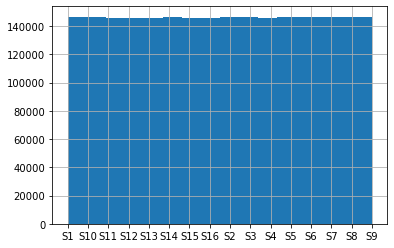

In [4]:
df_power['sub'].hist(bins=df_power['sub'].nunique())

# Default values

In [5]:
def_values_power = {
    'Artifact Removed': 'Yes',
    'EEG': 'Raw', 
    'Filter': 'Butterworth', 
    'Time': '-750ms', 
    'Method': 'Welch'
}
hue_order_power = {
    'Artifact Removed': ['Yes', 'No'],
    'EEG': ['Raw', 'Hjorth', 'M1 Average'], 
    'Filter': ['Blackmann-Harris', 'Butterworth'], 
    'Time': ['-250ms', '-750ms'], 
    'Method': ['FFT', 'Welch', 'Burg']
}
def_values_phase = {
    'Artifact Removed': 'Yes',
    'EEG': 'Raw',
    'Filter': 'Butterworth'
}

# PSDs across trial

--------------
Artifact Removed
--------------
Performing EEG = Raw for constant Artifact Removed, shape = (9599, 10)
Performing Filter = Butterworth for constant Artifact Removed, shape = (4799, 10)
Performing Time = -750ms for constant Artifact Removed, shape = (2400, 10)
Performing Method = Welch for constant Artifact Removed, shape = (800, 10)
--------------
EEG
--------------
Performing Artifact Removed = Yes for constant EEG, shape = (14399, 10)
Performing Filter = Butterworth for constant EEG, shape = (7199, 10)
Performing Time = -750ms for constant EEG, shape = (3600, 10)
Performing Method = Welch for constant EEG, shape = (1200, 10)
--------------
Filter
--------------
Performing Artifact Removed = Yes for constant Filter, shape = (14399, 10)
Performing EEG = Raw for constant Filter, shape = (4800, 10)
Performing Time = -750ms for constant Filter, shape = (2400, 10)
Performing Method = Welch for constant Filter, shape = (800, 10)
--------------
Time
--------------
Performing A

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


--------------
Method
--------------
Performing Artifact Removed = Yes for constant Method, shape = (14399, 10)
Performing EEG = Raw for constant Method, shape = (4800, 10)
Performing Filter = Butterworth for constant Method, shape = (2400, 10)
Performing Time = -750ms for constant Method, shape = (1200, 10)



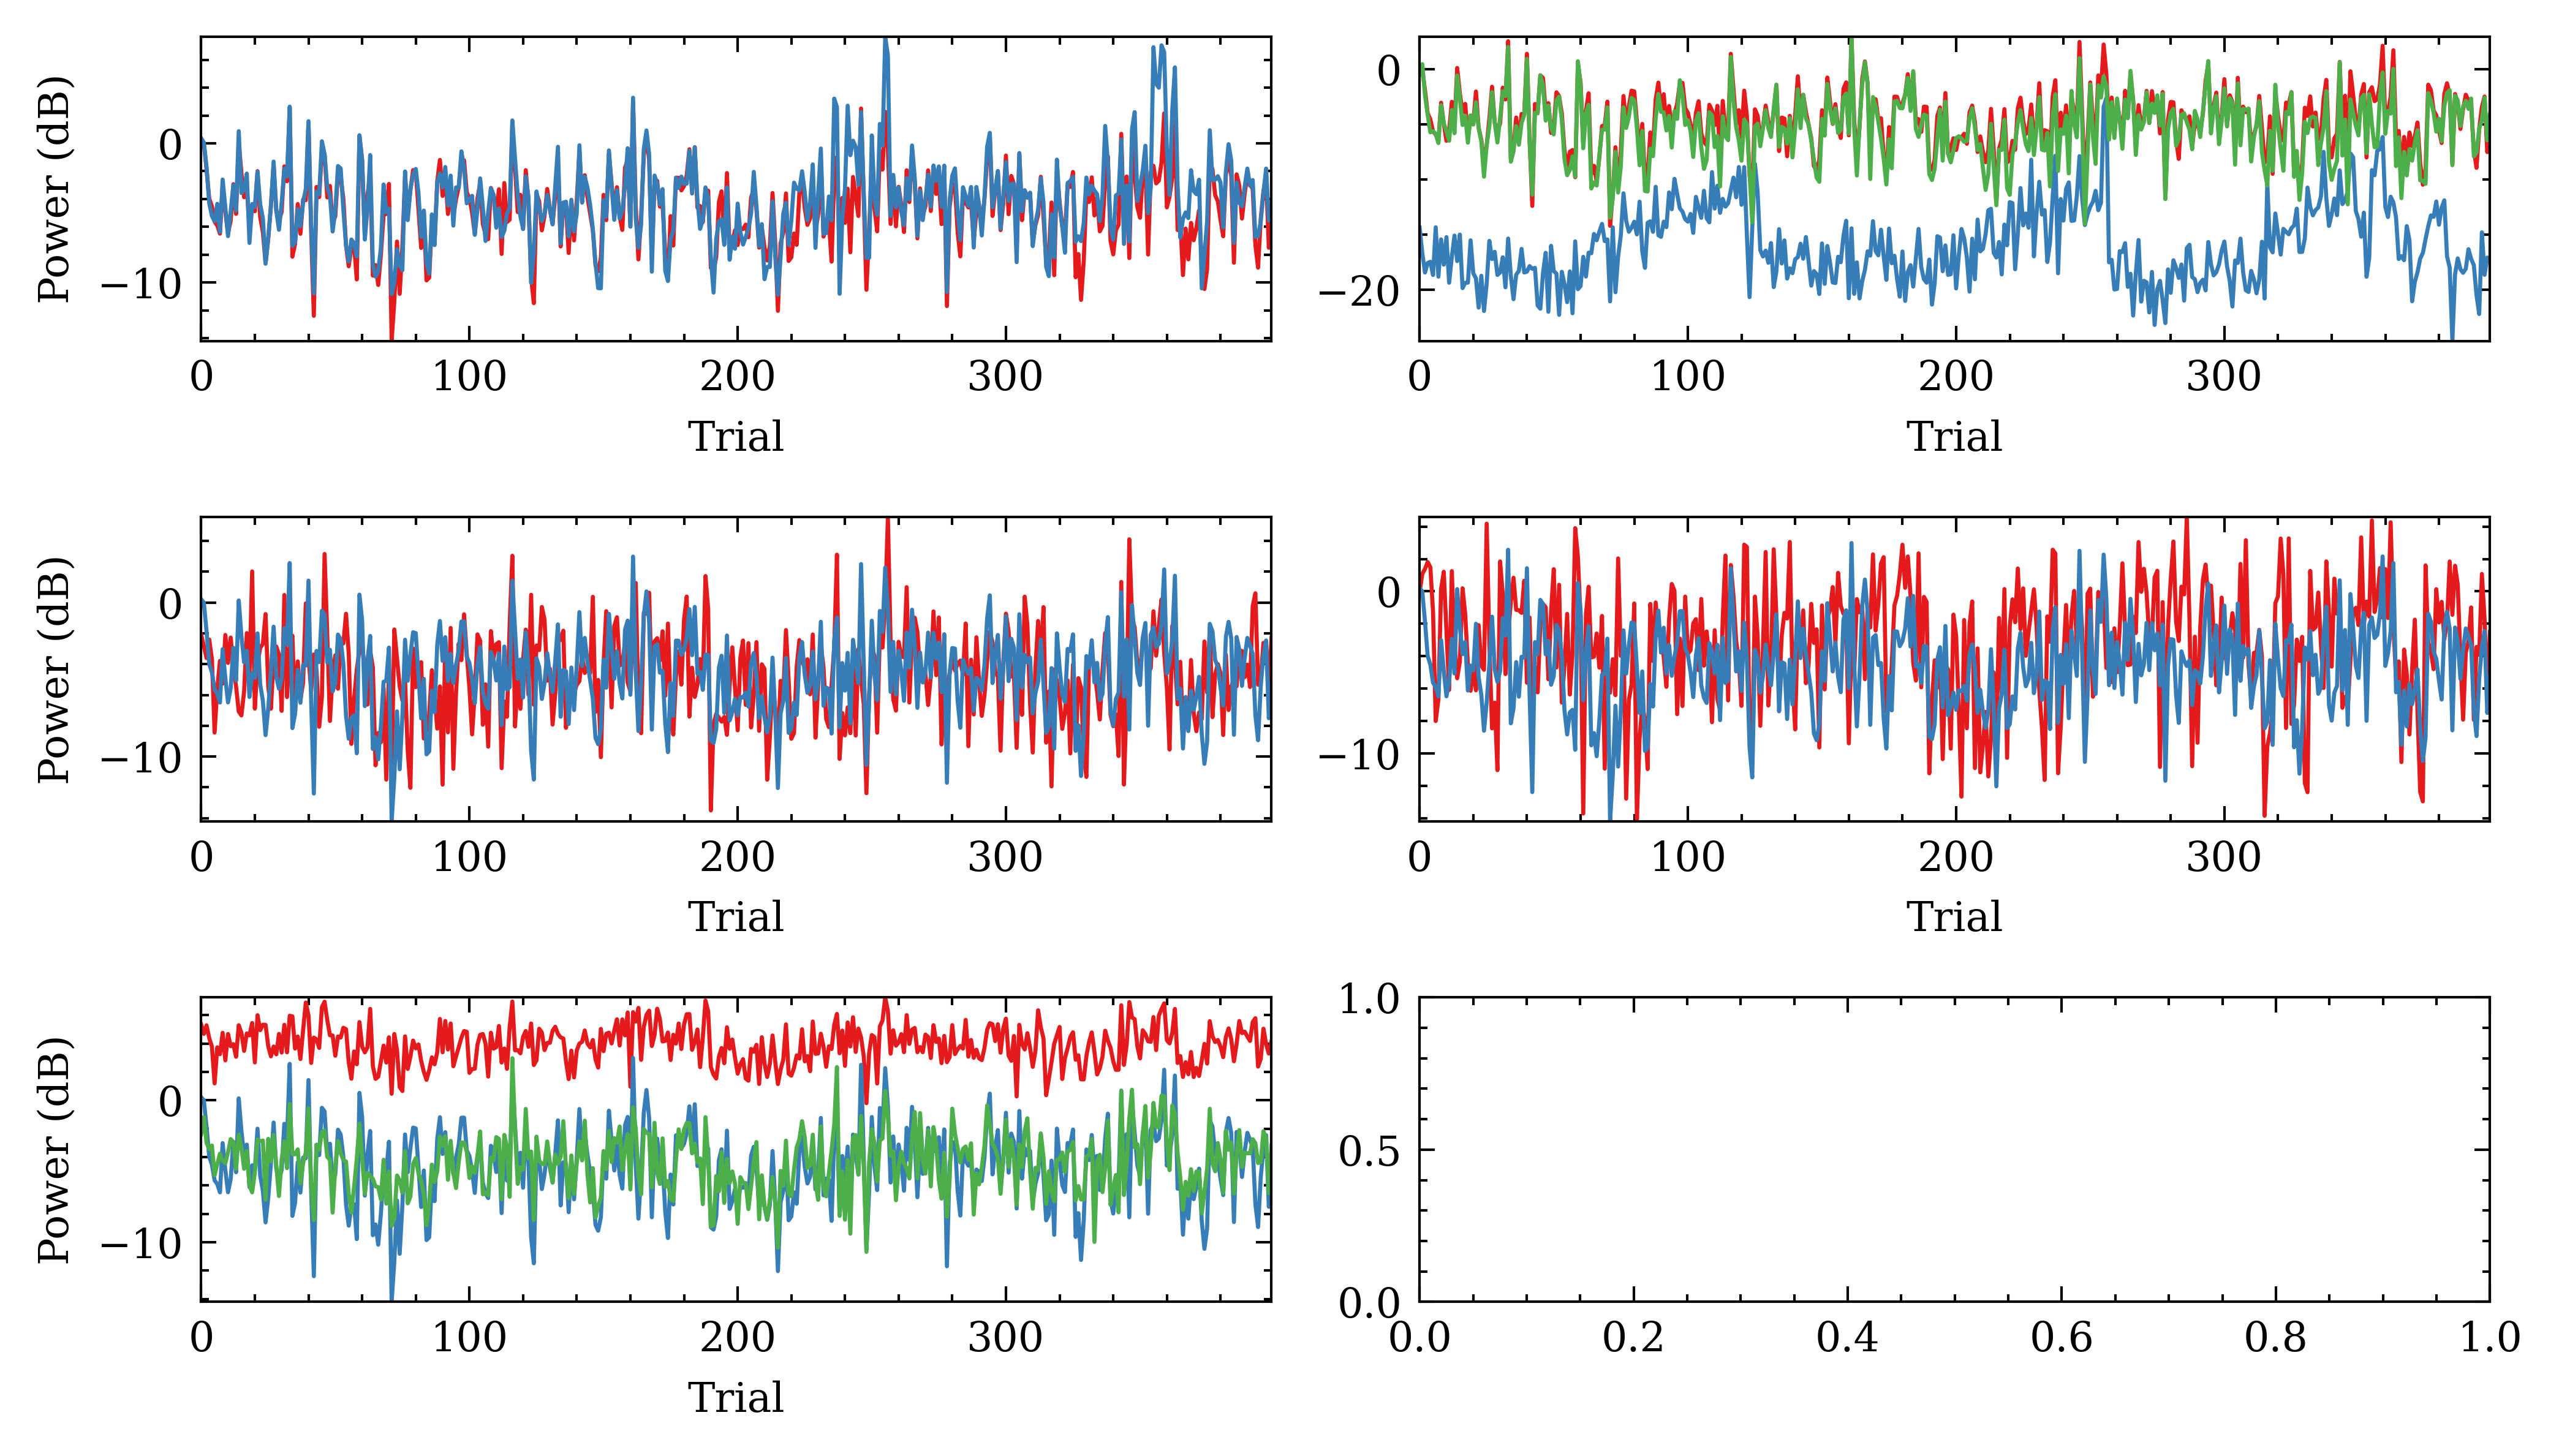

In [8]:
df_subject = df_power[df_power['sub'] == df_power['sub'].unique()[10]]
df_subject = df_subject[df_subject['trial_abs'] < 400]
eegplot.power_trial_plot(df_subject, 'Beta', def_values_power, hue_order_power, None, False)

# Box plots - PSD

--------------
Artifact Removed
--------------
Performing EEG = Raw for constant Artifact Removed, shape = (48572, 10)
Performing Filter = Butterworth for constant Artifact Removed, shape = (24284, 10)
Performing Time = -750ms for constant Artifact Removed, shape = (12144, 10)
Performing Method = Welch for constant Artifact Removed, shape = (4048, 10)
--------------
EEG
--------------
Performing Artifact Removed = Yes for constant EEG, shape = (72860, 10)
Performing Filter = Butterworth for constant EEG, shape = (36428, 10)
Performing Time = -750ms for constant EEG, shape = (18216, 10)
Performing Method = Welch for constant EEG, shape = (6072, 10)
--------------
Filter
--------------
Performing Artifact Removed = Yes for constant Filter, shape = (72860, 10)
Performing EEG = Raw for constant Filter, shape = (24288, 10)
Performing Time = -750ms for constant Filter, shape = (12144, 10)
Performing Method = Welch for constant Filter, shape = (4048, 10)
--------------
Time
--------------
Per

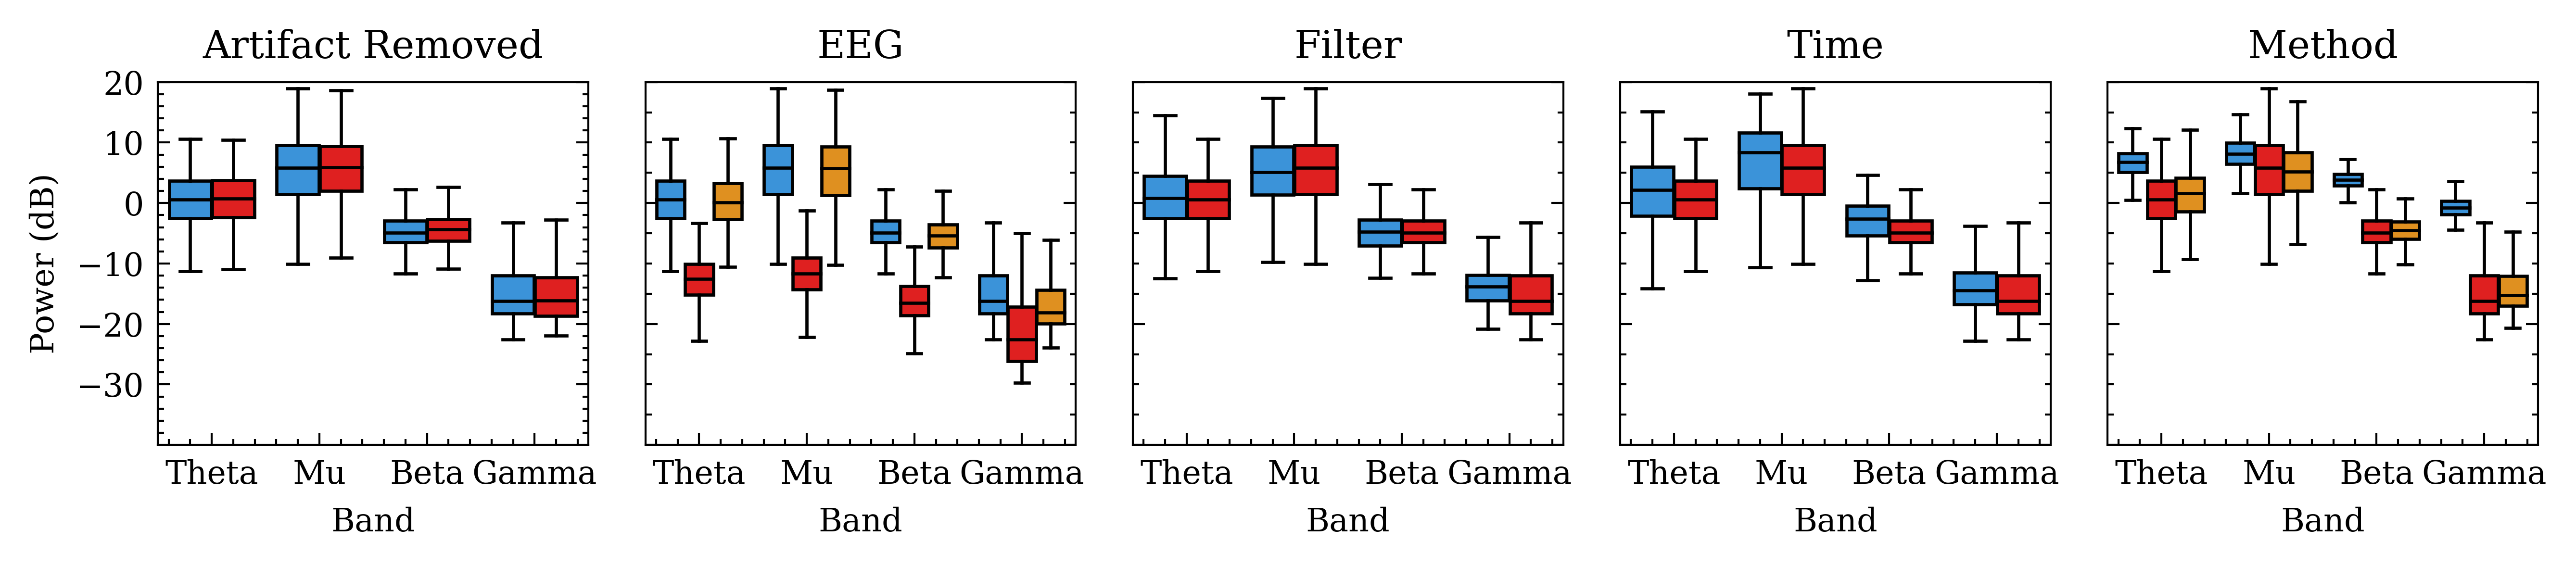

In [12]:
df_subject = df_power[df_power['sub'] == df_power['sub'].unique()[10]]
eegplot.power_box_plot(df_subject, def_values_power, hue_order_power, y_lim=[-40, 20], y_ticks=[-30, -20, -10, 0, 10, 20], show_legend=False)

# Interaction plot - PSD

Plotting in (0, 0): ('Artifact Removed', 'EEG'), shape: (3036, 10), unique1: ['No' 'Yes'], unique2: ['Raw' 'Hjorth' 'M1 Average']
Plotting in (0, 1): ('Artifact Removed', 'Filter'), shape: (2024, 10), unique1: ['No' 'Yes'], unique2: ['Butterworth' 'Blackmann-Harris']
Plotting in (0, 2): ('Artifact Removed', 'Time'), shape: (2024, 10), unique1: ['No' 'Yes'], unique2: ['-750ms' '-250ms']
Plotting in (0, 3): ('Artifact Removed', 'Method'), shape: (3036, 10), unique1: ['No' 'Yes'], unique2: ['Burg' 'Welch' 'FFT']
Plotting in (0, 4): ('EEG', 'Filter'), shape: (3036, 10), unique1: ['Raw' 'Hjorth' 'M1 Average'], unique2: ['Butterworth' 'Blackmann-Harris']
Plotting in (1, 0): ('EEG', 'Time'), shape: (3036, 10), unique1: ['Raw' 'Hjorth' 'M1 Average'], unique2: ['-750ms' '-250ms']
Plotting in (1, 1): ('EEG', 'Method'), shape: (4554, 10), unique1: ['Raw' 'Hjorth' 'M1 Average'], unique2: ['Burg' 'Welch' 'FFT']
Plotting in (1, 2): ('Filter', 'Time'), shape: (2024, 10), unique1: ['Butterworth' 'Blac

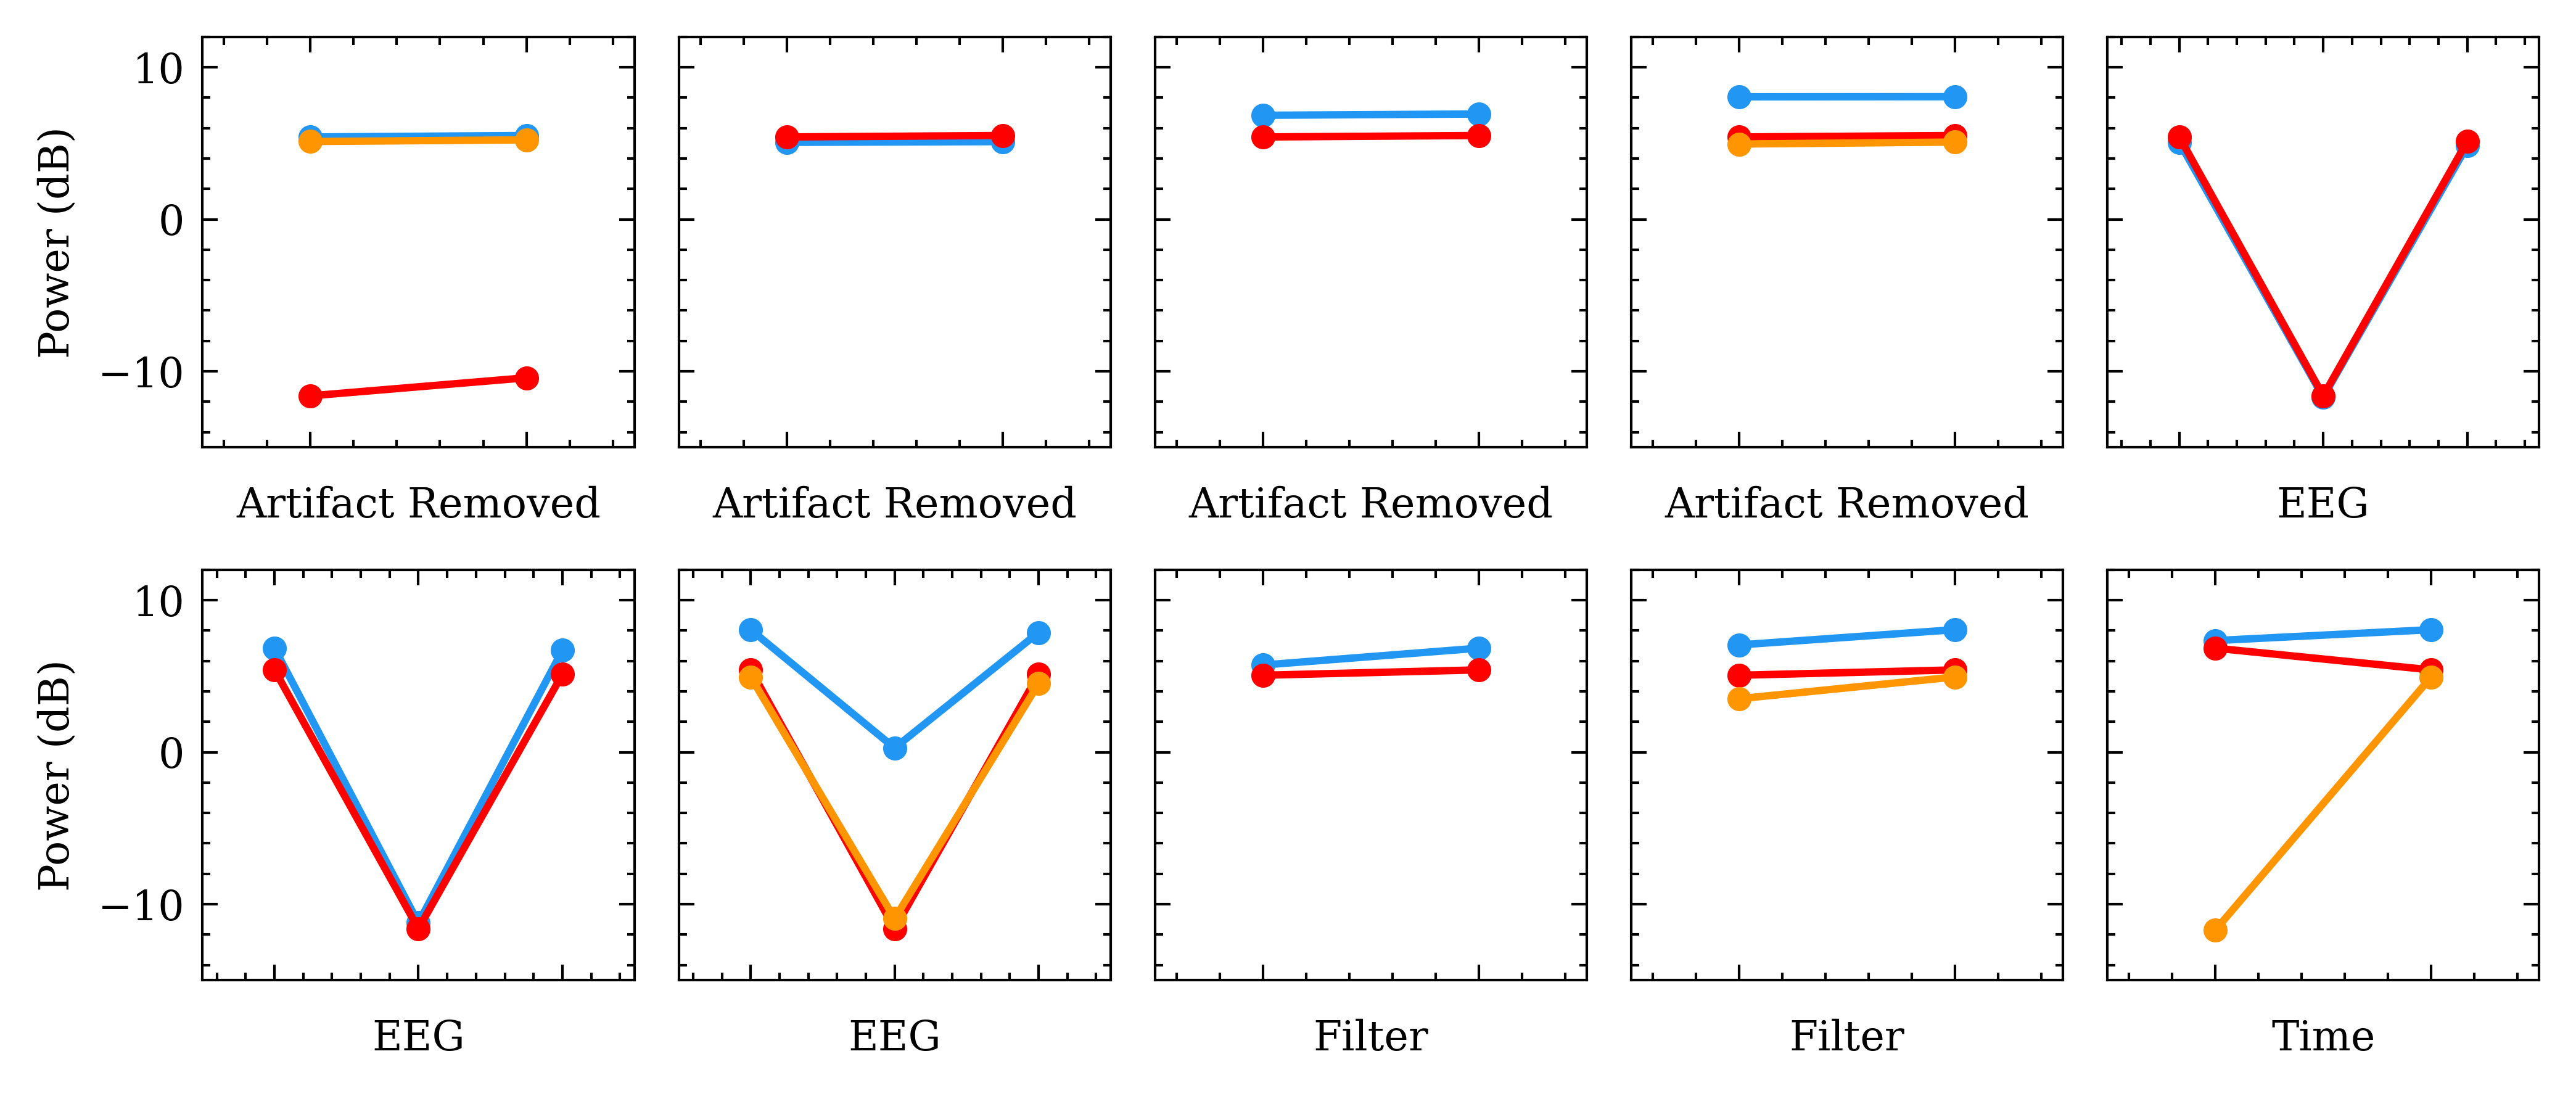

In [9]:
df_subject = df_power[df_power['sub'] == df_power['sub'].unique()[10]]
eegplot.power_interaction_plot(df_subject, def_values_power, 'Mu', hue_order_power, y_lim=[-15, 12], show_legend=False, hide_tick_labels=True)

# Histogram - phases

Artifact Removed, Band: Theta, Options: ['No' 'Yes']
Artifact Removed, Band: Mu, Options: ['No' 'Yes']
Artifact Removed, Band: Beta, Options: ['No' 'Yes']
Artifact Removed, Band: Gamma, Options: ['No' 'Yes']
EEG, Band: Theta, Options: ['Raw' 'Hjorth' 'M1 Average']
EEG, Band: Mu, Options: ['Raw' 'Hjorth' 'M1 Average']
EEG, Band: Beta, Options: ['Raw' 'Hjorth' 'M1 Average']
EEG, Band: Gamma, Options: ['Raw' 'Hjorth' 'M1 Average']


/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

Filter, Band: Theta, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Mu, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Beta, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Gamma, Options: ['Butterworth' 'Blackmann-Harris']



/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

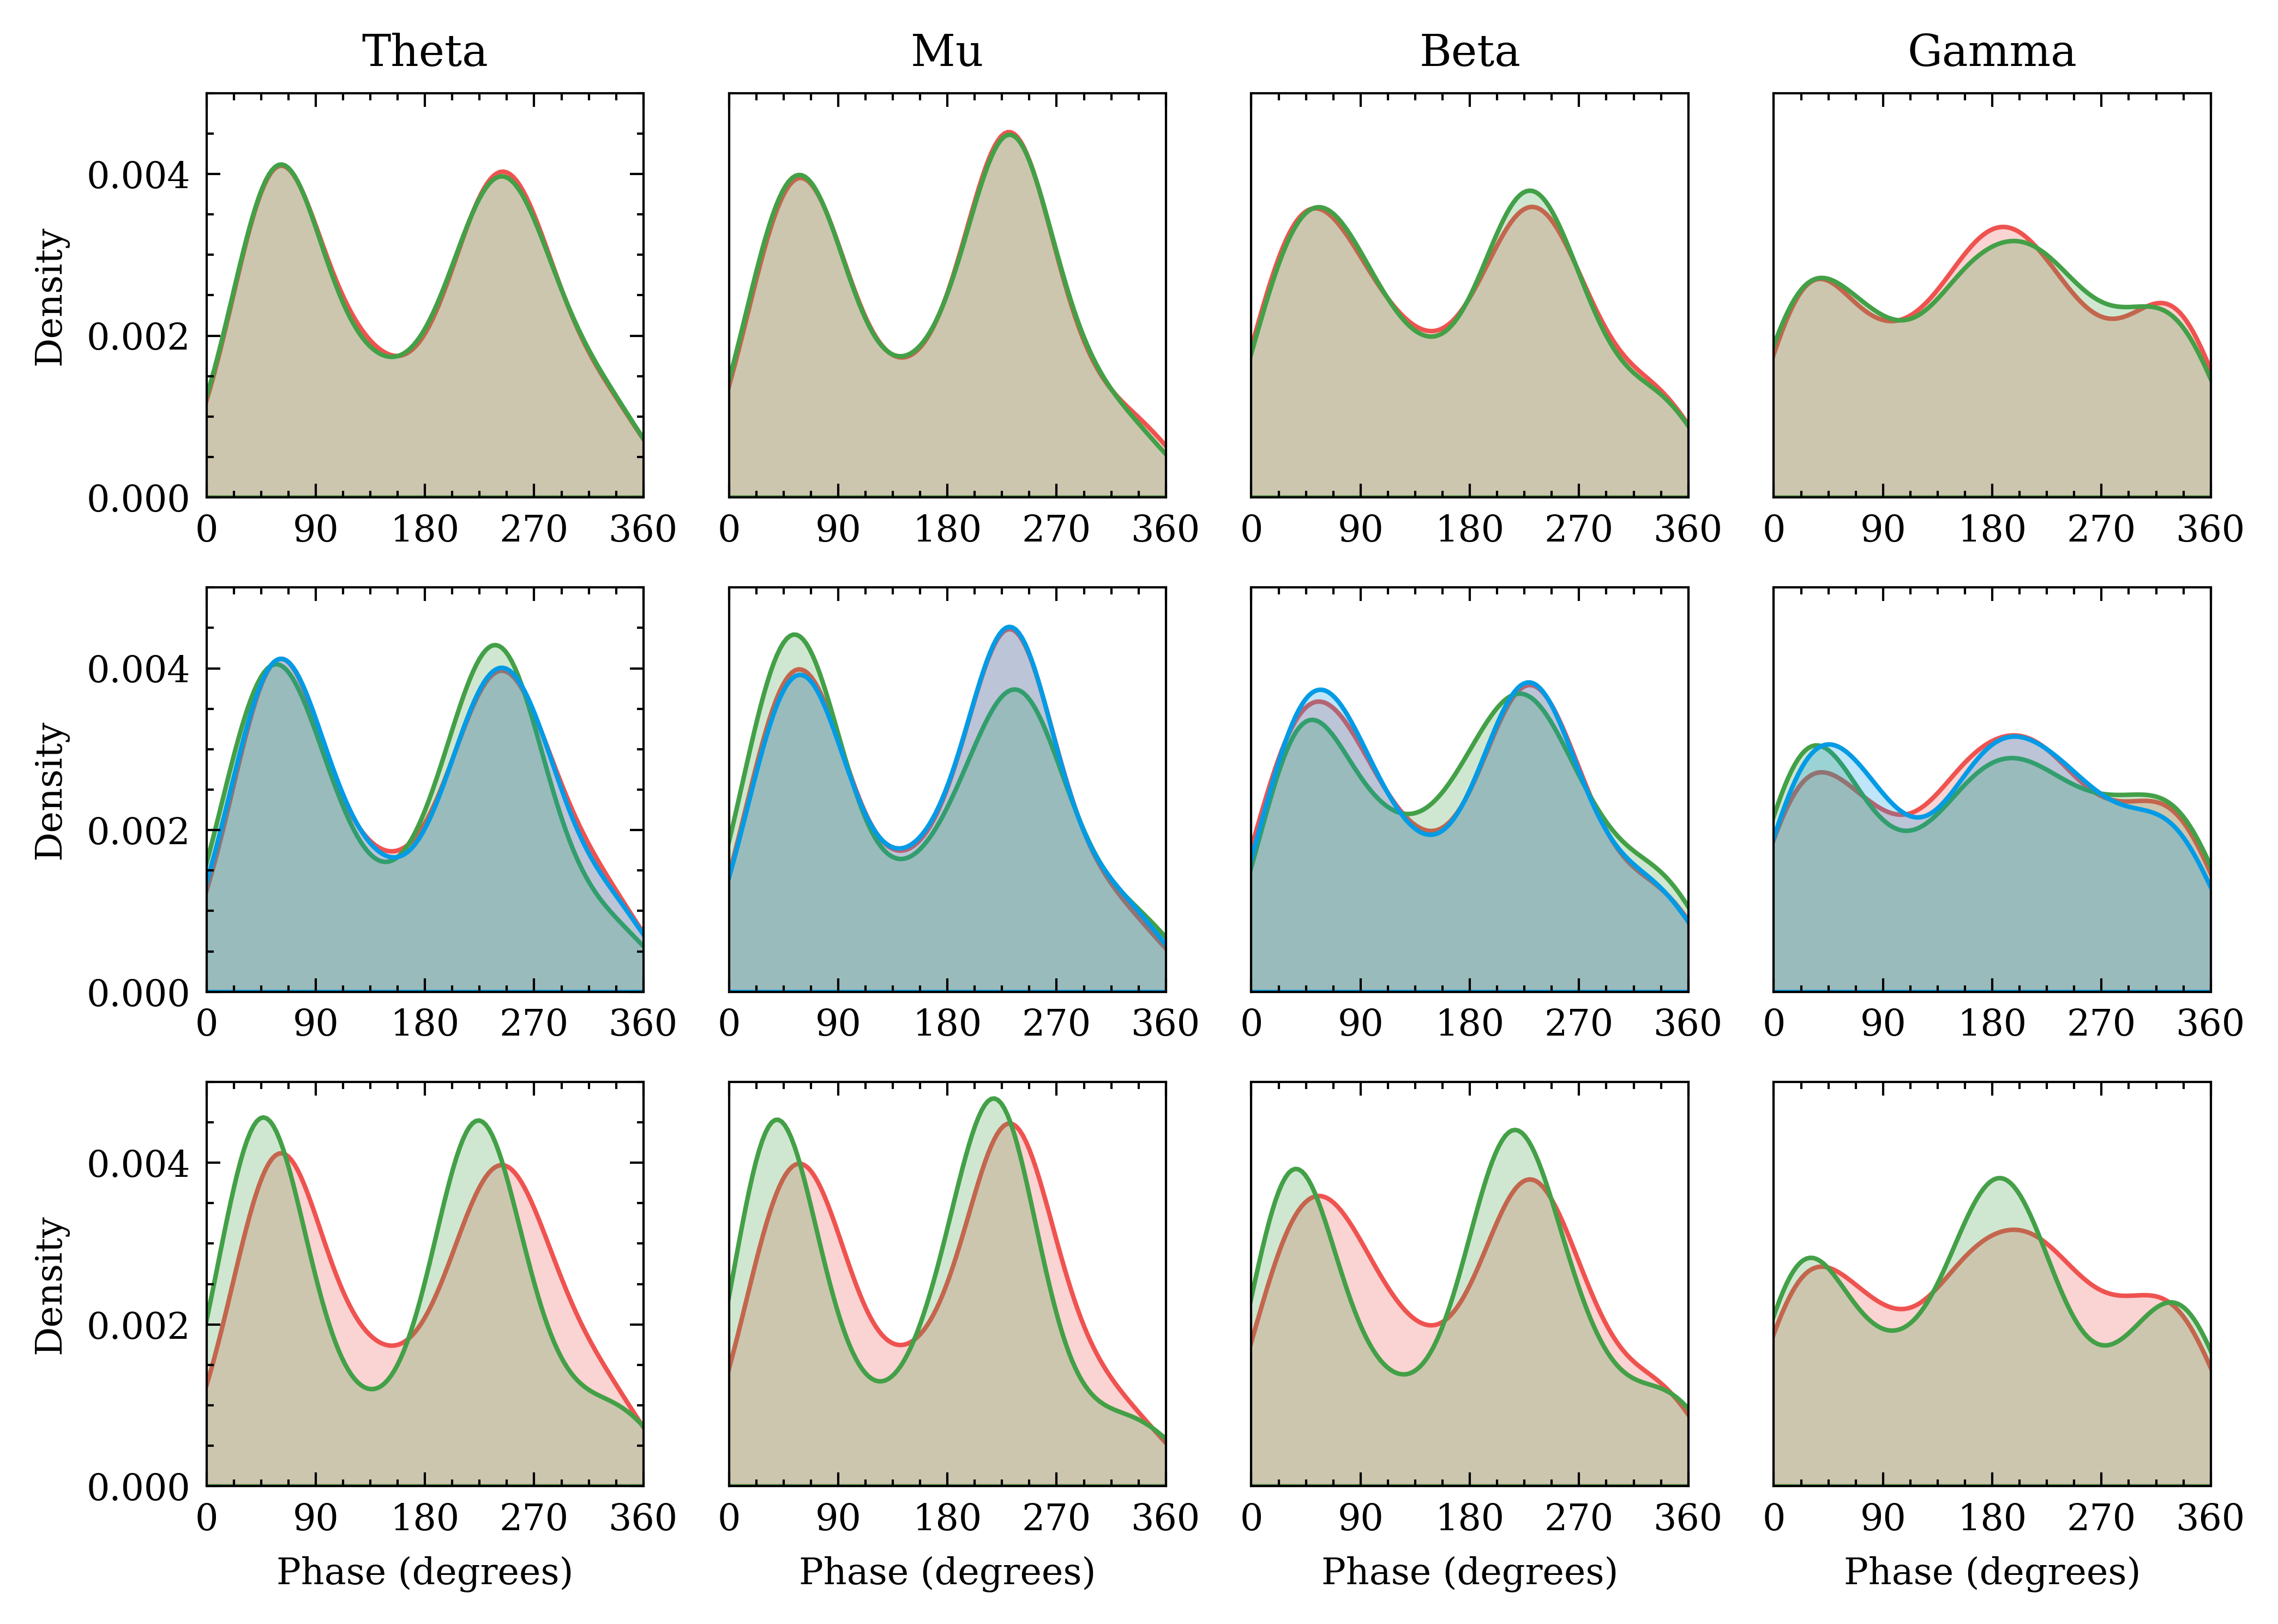

In [7]:
df_subject = df_phase[df_phase['sub'] == df_phase['sub'].unique()[10]]
eegplot.phase_hist_plot(df_subject, def_values_phase, y_lim=[0, 0.005])

# Correlation - power

In [8]:
df_corr = []
for sub in tqdm(df_power['sub'].unique()):
    df_sub = df_power[df_power['sub'] == sub]
    for key, val in def_values_power.items():
        df2 = df_sub
        for key2, val2 in def_values_power.items():
            if key != key2:
                df2 = df2[df2[key2] == val2]
        combs = list(combinations(sorted(df2[key].unique()), 2))
        for band in df_power['Band'].unique():
            df3 = df2[df2['Band'] == band]
            for value_pair in combs:
                data1 = df3[df3[key] == value_pair[0]]['Power'].values
                data2 = df3[df3[key] == value_pair[1]]['Power'].values
                corr, _ = pearsonr(data1, data2)
                # print('sub: {}, band: {}, factor: {}, shape: [{}, {}]'.format(sub, band, key, data1.shape[0], data2.shape[0]))
                df_corr.append({
                    'subject': sub,
                    'band': band,
                    'factor': key,
                    'value_1': value_pair[0],
                    'value_2': value_pair[1],
                    'Correlation': corr
                })
                
df_corr = pd.DataFrame(df_corr)
df_corr['factor_value'] = df_corr.apply(lambda x: '{}: {} vs {}'.format(x['factor'], x['value_1'], x['value_2']), axis=1)
df_corr.head()

,subject,band,factor,value_1,value_2,Correlation,factor_value
0,S1,Theta,Artifact Removed,No,Yes,0.986805,Artifact Removed: No vs Yes
1,S1,Mu,Artifact Removed,No,Yes,0.997045,Artifact Removed: No vs Yes
2,S1,Beta,Artifact Removed,No,Yes,0.986474,Artifact Removed: No vs Yes
3,S1,Gamma,Artifact Removed,No,Yes,0.931056,Artifact Removed: No vs Yes
4,S1,Theta,EEG,Hjorth,M1 Average,0.086998,EEG: Hjorth vs M1 Average


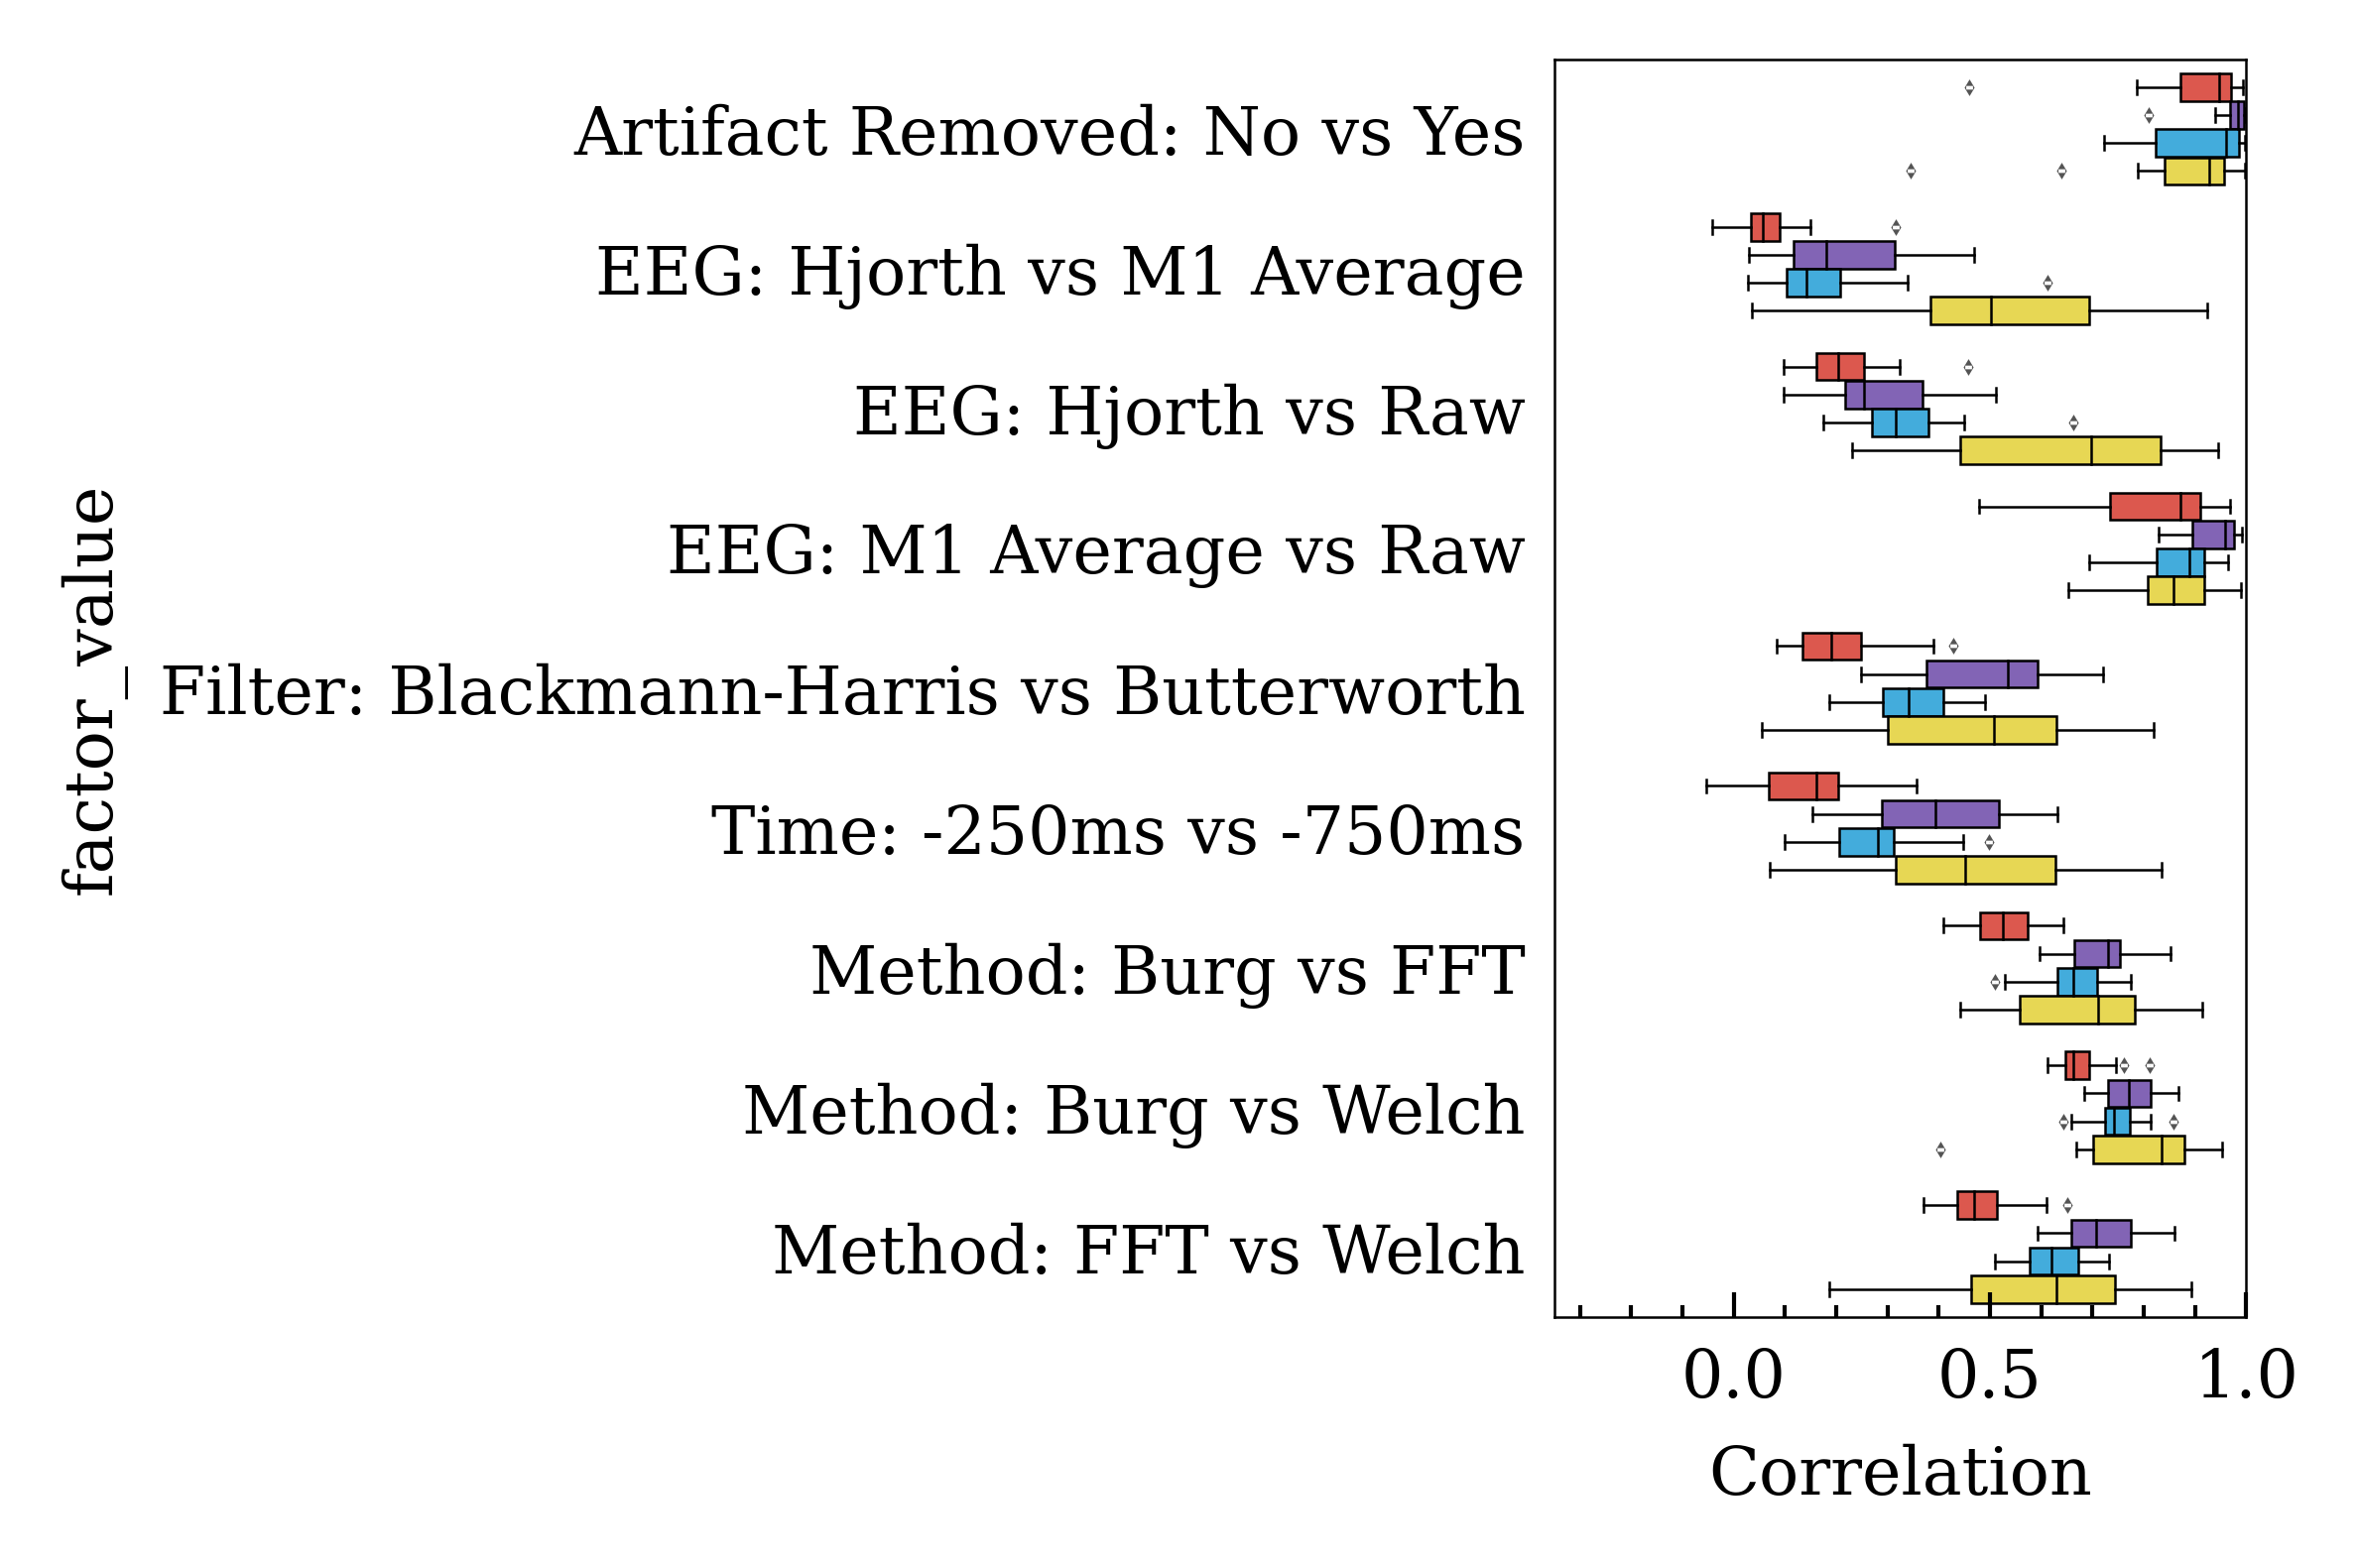

In [9]:
eegplot.power_corr_plot(df_corr, x_lim=[-.35, 1], x_ticks=[0, .5, 1])

# Correlation - phase

In [10]:
def_values_phase2 = {
    'Artifact Removed': 'Yes',
    'EEG': 'M1 Average',
    'Filter': 'Blackmann-Harris'
}

df_phase_peak = df_phase[df_phase['Phase'] < 180]
df_phase_trough = df_phase[df_phase['Phase'] >= 180]
df_corr = []
for grp_name, df_phase_grp in zip(['peak', 'trough'], [df_phase_peak, df_phase_trough]):
    for sub in tqdm(df_phase_grp['sub'].unique()):
        df_sub = df_phase_grp[df_phase_grp['sub'] == sub]
        for key, val in def_values_phase2.items():
            df2 = df_sub
            for key2, val2 in def_values_phase2.items():
                if key != key2:
                    df2 = df2[df2[key2] == val2]
            combs = list(combinations(sorted(df2[key].unique()), 2))
            for band in df_phase['Band'].unique():
                df3 = df2[df2['Band'] == band]
                for value_pair in combs:
                    data1 = df3[df3[key] == value_pair[0]]['Phase'].values
                    data2 = df3[df3[key] == value_pair[1]]['Phase'].values
                    mn = np.min([data1.shape[0], data2.shape[0]])
                    data1 = data1[0:mn]
                    data2 = data2[0:mn]
                    corr, _ = pearsonr(data1, data2)
                    # print('sub: {}, band: {}, factor: {}, shape: [{}, {}]'.format(sub, band, key, data1.shape[0], data2.shape[0]))
                    df_corr.append({
                        'subject': sub,
                        'band': band,
                        'group': grp_name,
                        'factor': key,
                        'value_1': value_pair[0],
                        'value_2': value_pair[1],
                        'Correlation': corr
                    })
                    
df_corr = pd.DataFrame(df_corr)
df_corr['factor_value'] = df_corr.apply(lambda x: '{}: {} vs {}'.format(x['factor'], x['value_1'], x['value_2']), axis=1)
df_corr.head()

,subject,band,group,factor,value_1,value_2,Correlation,factor_value
0,S1,Theta,peak,Artifact Removed,No,Yes,-0.020422,Artifact Removed: No vs Yes
1,S1,Mu,peak,Artifact Removed,No,Yes,0.073927,Artifact Removed: No vs Yes
2,S1,Beta,peak,Artifact Removed,No,Yes,0.293247,Artifact Removed: No vs Yes
3,S1,Gamma,peak,Artifact Removed,No,Yes,0.366745,Artifact Removed: No vs Yes
4,S1,Theta,peak,EEG,Hjorth,M1 Average,0.059267,EEG: Hjorth vs M1 Average


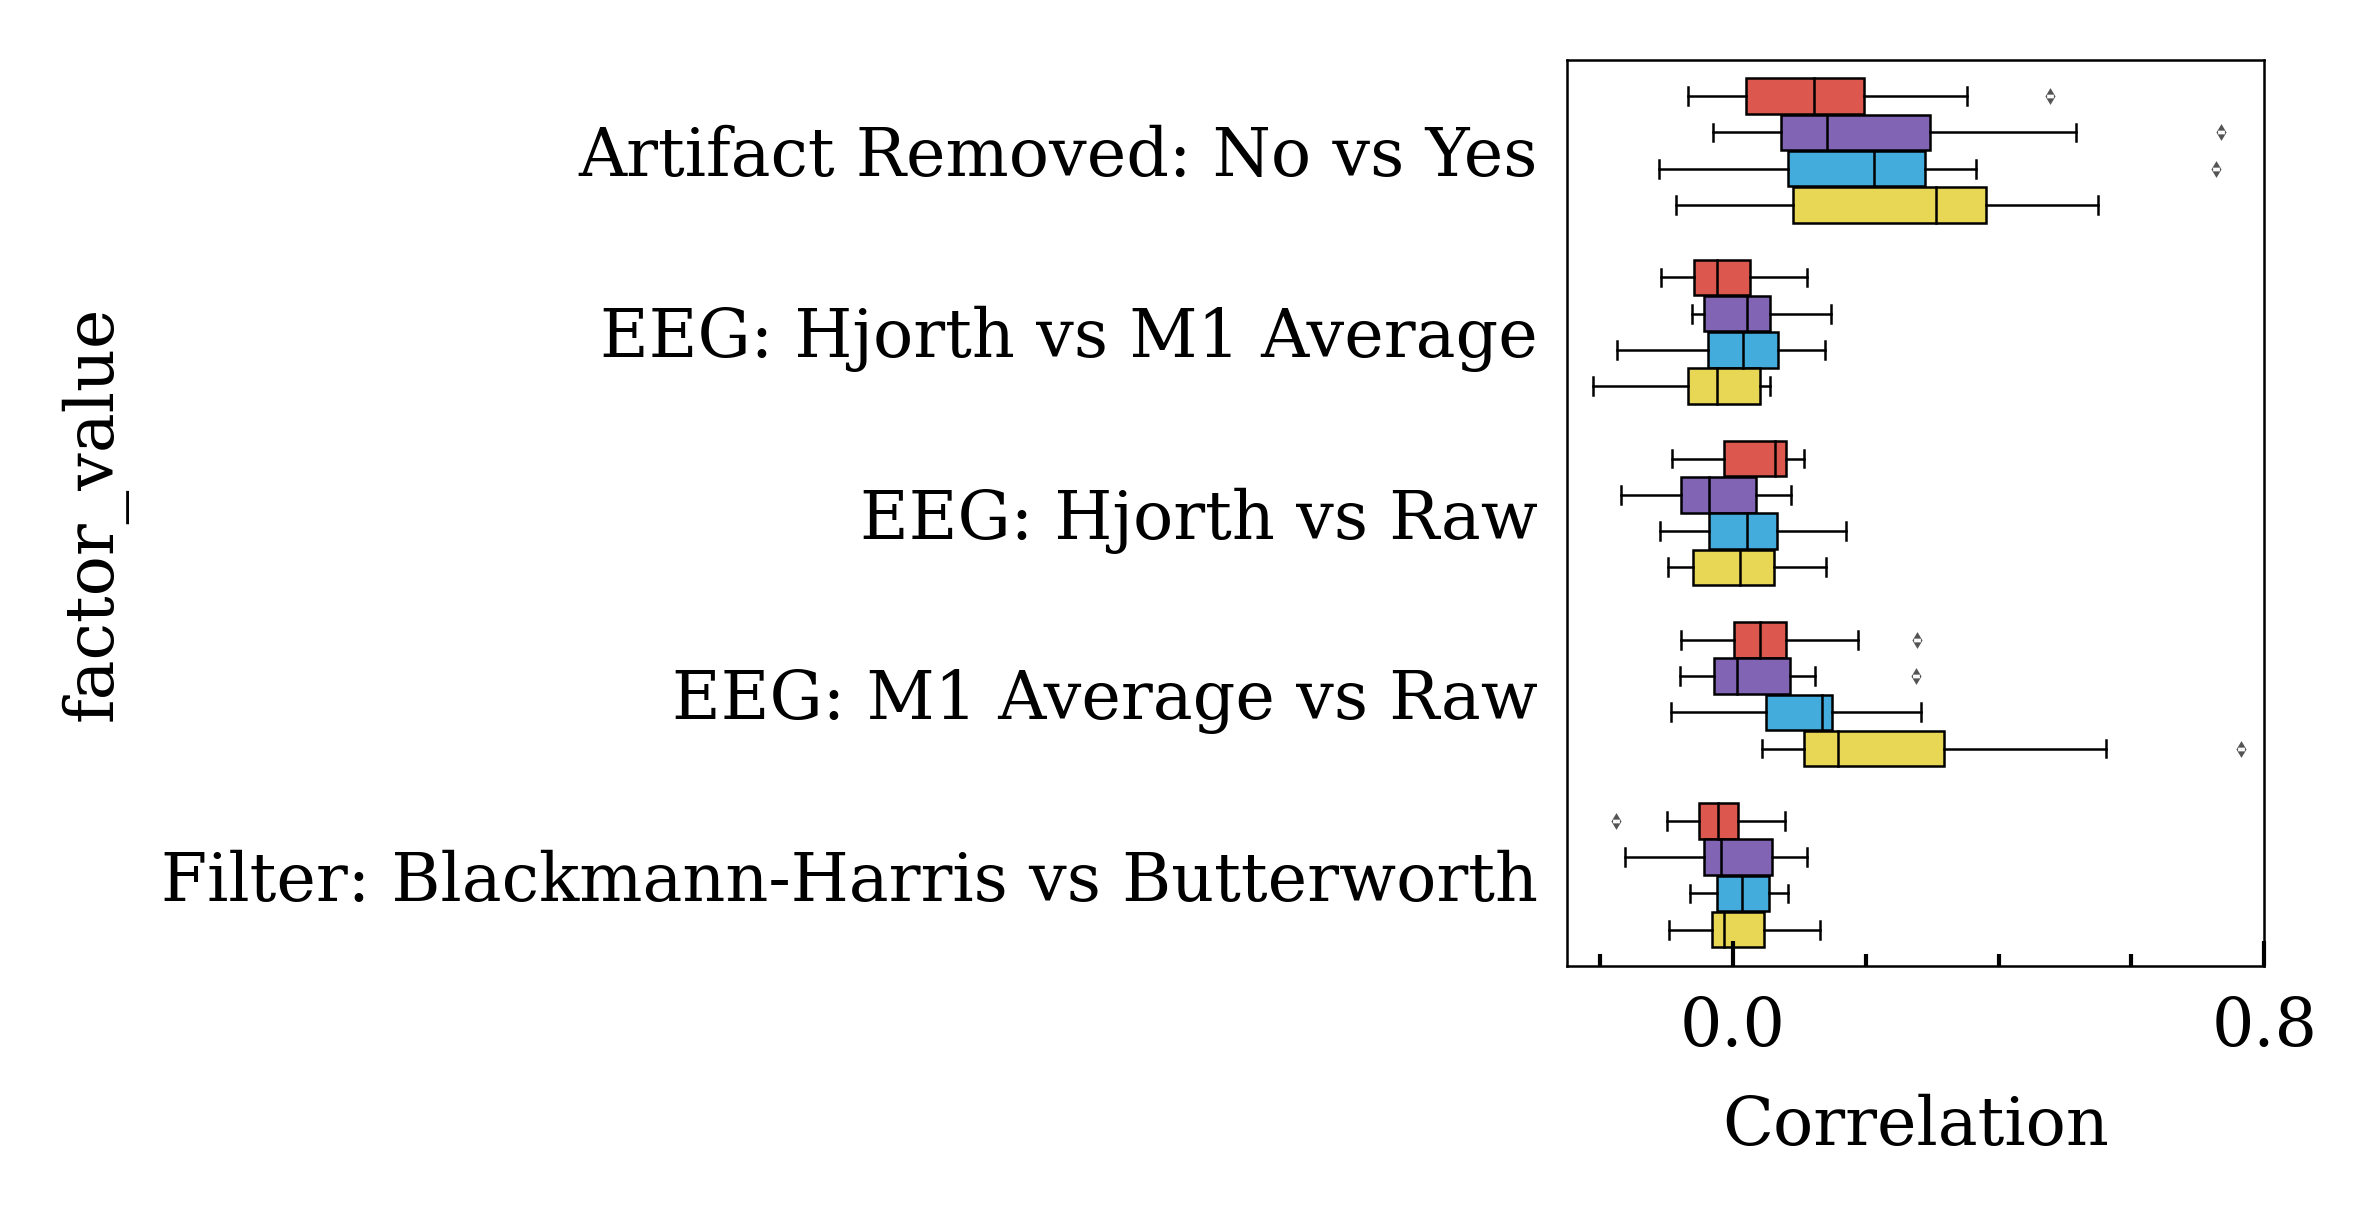

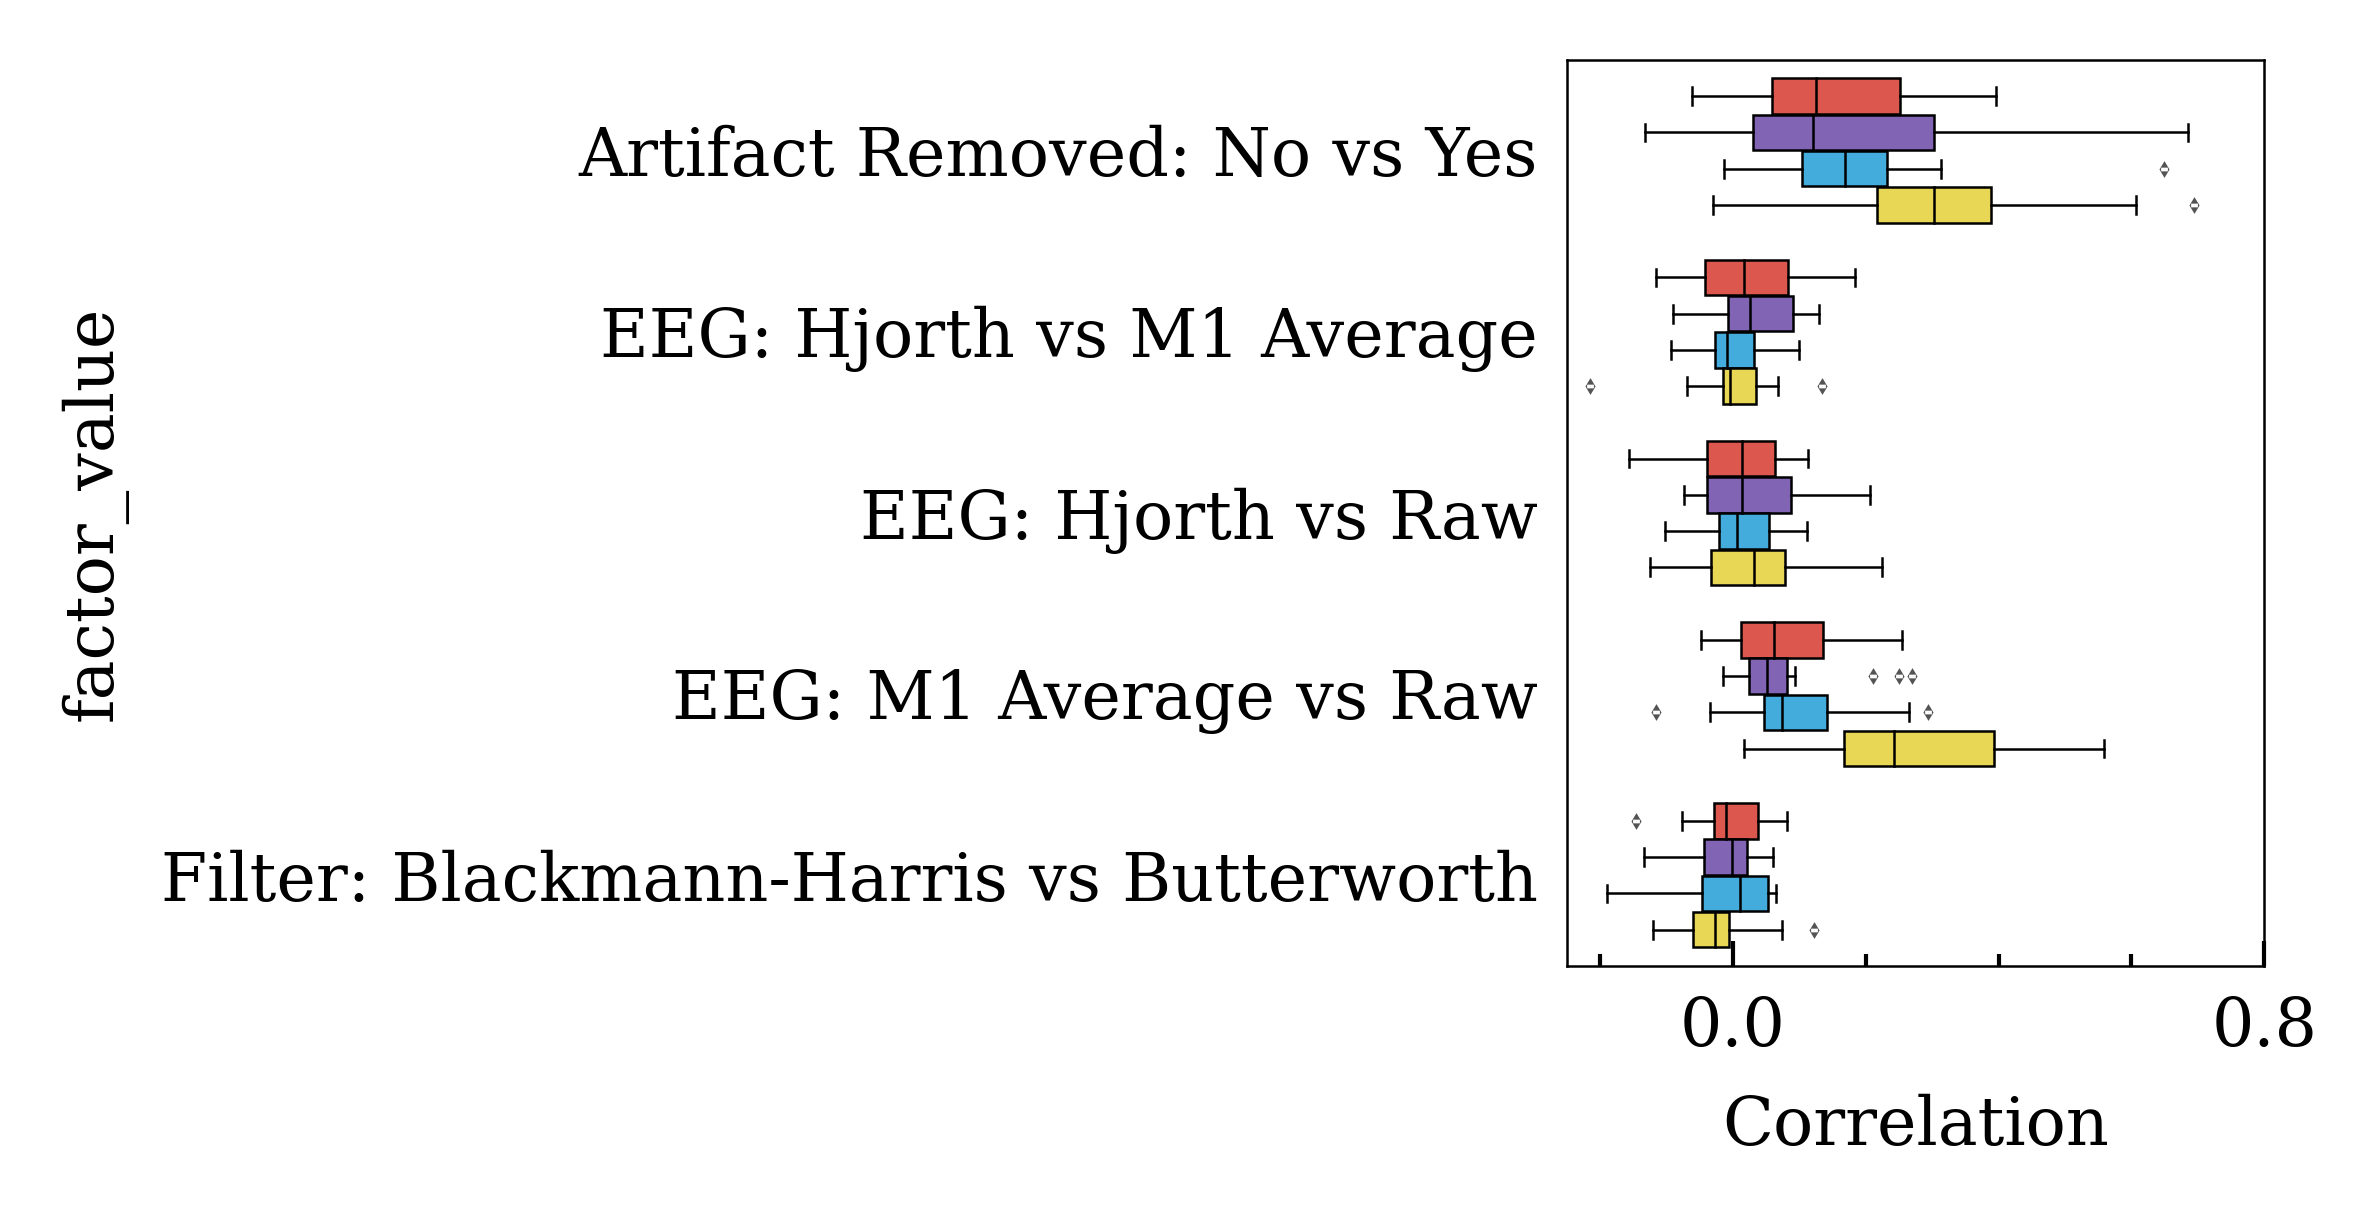

In [11]:
eegplot.phase_corr_plots(df_corr, x_lim=[-0.25, 0.8], x_ticks=[0, .8])